In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn.functional as F
import numpy as np
import pickle

In [6]:
torch.cuda.is_available()

True

In [7]:
# Load in the data
X1_train = pd.read_parquet('../../data/preprocessed/holdout_1.pq')
X1_test = pd.read_parquet('../../data/preprocessed/thursdays.pq')
y1_train = pd.read_parquet('../../data/preprocessed/holdout_1_y.pq')
y1_test = pd.read_parquet('../../data/preprocessed/thursdays_y.pq')

# Data for Day Model
X1_train_day = X1_train[X1_train['day_time'] == 1]
y1_train_day = y1_train[X1_train['day_time'] == 1]
X1_test_day = X1_test[X1_test['day_time'] == 1]
y1_test_day = y1_test[X1_test['day_time'] == 1]

# Data for Night Model
X1_train_night = X1_train[X1_train['day_time'] == 0]
y1_train_night = y1_train[X1_train['day_time'] == 0]
X1_test_night = X1_train[X1_train['day_time'] == 0]
y1_test_night = y1_train[X1_train['day_time'] == 0]

X1_train_day = X1_train_day.drop(columns=['day_time', 'night_time'])
X1_test_day = X1_test_day.drop(columns=['day_time', 'night_time'])
X1_train_night = X1_train_night.drop(columns=['day_time', 'night_time'])
X1_test_night = X1_test_night.drop(columns=['day_time', 'night_time'])

In [8]:
train_x = X1_train_day
train_y = y1_train_day

In [9]:
print(train_x.shape)
print(train_x.columns)
train_x = train_x.drop(columns=['hour', 'minute'])
print(train_x.shape)
print(train_x.columns)

(307020, 16)
Index(['ProzessData_ActData_AB1_Analogs_DX1_MassPressure',
       'ProzessData_ActData_AB1_Analogs_GY1_MassLevelTank',
       'ProzessData_ActData_AB1_Current_DV1_Scraper',
       'ProzessData_ActData_AB1_Current_DW1_RiserPumpFwd',
       'ProzessData_ActData_AB1_Speed_DV1_Scraper',
       'ProzessData_ActData_AB1_Speed_DW1_RiserPumpFwd',
       'ProzessData_ActData_AB1_Temperature_DP1_MassHeatingStage',
       'ProzessData_ActData_AB1_Temperature_DP1_WaterHeatingStage',
       'ProzessData_ActData_AB1_Temperature_DQ1_MassCoolingStage',
       'ProzessData_ActData_AB1_Temperature_DQ1_WaterCoolingStage',
       'ProzessData_ActData_AB1_Temperature_DR1_WaterMixingStage',
       'ProzessData_ActData_AB1_Temperature_DS1_WaterPipe',
       'ProzessData_ActData_AB1_Temperature_DU1_WaterTank',
       'ProzessData_ActData_AB1_Temperature_DX1_MassInfeed', 'hour', 'minute'],
      dtype='object')
(307020, 14)
Index(['ProzessData_ActData_AB1_Analogs_DX1_MassPressure',
       'Prozess

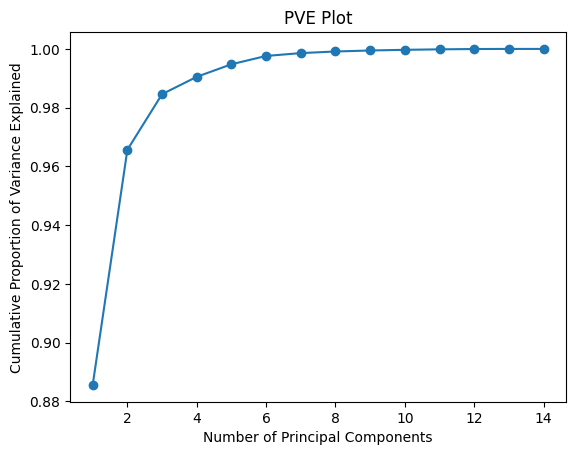

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_column = 'ProzessData_ActData_AB1_Temperature_DR1_MassMixingStage'

# Normalize features in train_x (excluding the timestamp column)
scaler_x = StandardScaler()
train_x_scaled = scaler_x.fit_transform(train_x.to_numpy())  # Adjust if the first column isn't the timestamp

# Perform PCA
pca = PCA()
X1_train_day_pca = pca.fit_transform(train_x_scaled)

# Calculate the proportion of variance explained
pve = pca.explained_variance_ratio_
cumulative_pve = np.cumsum(pve)

# Plot the PVE
plt.plot(range(1, len(pve) + 1), cumulative_pve, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.title('PVE Plot')
plt.show()

In [11]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=3)
train_x_pca = pca.fit_transform(train_x_scaled)

In [12]:
from sklearn.decomposition import PCA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_column = 'ProzessData_ActData_AB1_Temperature_DR1_MassMixingStage'

train_x_tensor = torch.tensor(train_x_pca).float().unsqueeze(1) # train_x_scaled

# scaler_y = StandardScaler()
# train_y_scaled = scaler_y.fit_transform(train_y[[target_column]])
train_y_tensor = torch.tensor(train_y.to_numpy()).float() # train_y_scaled

# DataLoader
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # changed to False

In [17]:
# Prefixed
input_dim = 3

# Goal: MAE: 0.0559
weight_decay=0.001
clip_value=6.480203110123226
hidden_dim=32
num_layers=3
dropout_rate=0.10901259861276512
lr=0.0006423716455944324
batch_size=32

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim, 1) 

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

model = LSTMModel(input_dim, hidden_dim, num_layers, dropout_rate).to(device)

# Loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# DataLoader
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle False

num_epochs = 30
print(f'Hyperparameters: hidden_dim={hidden_dim}, num_layers={num_layers}, dropout_rate={dropout_rate}, lr={lr}, batch_size={batch_size}')
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        # inputs = inputs.view(744, -1)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}')
print("Training finished")

Hyperparameters: hidden_dim=32, num_layers=3, dropout_rate=0.10901259861276512, lr=0.0006423716455944324, batch_size=32
Epoch 1/30, Loss: 0.3487
Epoch 2/30, Loss: 0.1316
Epoch 3/30, Loss: 0.2413
Epoch 4/30, Loss: 0.1685
Epoch 5/30, Loss: 0.0647
Epoch 6/30, Loss: 0.1415
Epoch 7/30, Loss: 0.2896
Epoch 8/30, Loss: 0.0740
Epoch 9/30, Loss: 0.0742
Epoch 10/30, Loss: 0.0734
Epoch 11/30, Loss: 0.2281
Epoch 12/30, Loss: 0.0711
Epoch 13/30, Loss: 0.1907
Epoch 14/30, Loss: 0.0523
Epoch 15/30, Loss: 0.0961
Epoch 16/30, Loss: 0.1297
Epoch 17/30, Loss: 0.0881
Epoch 18/30, Loss: 0.0681
Epoch 19/30, Loss: 0.2327
Epoch 20/30, Loss: 0.0346
Epoch 21/30, Loss: 0.0564
Epoch 22/30, Loss: 0.0555
Epoch 23/30, Loss: 0.2396
Epoch 24/30, Loss: 0.1227
Epoch 25/30, Loss: 0.0455
Epoch 26/30, Loss: 0.1720
Epoch 27/30, Loss: 0.3578
Epoch 28/30, Loss: 0.0959
Epoch 29/30, Loss: 0.0284
Epoch 30/30, Loss: 0.0710
Training finished


## Save Model

In [20]:
# Define your values
output_dim = train_y_tensor.shape[1]  # Should be 1 as we're predicting a single target

# Create a dictionary that includes the model state and the additional values
model_info = {
    'state_dict': model.state_dict(),
    'input_dim': input_dim,
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout_rate': dropout_rate,
    'output_dim': output_dim
}

# Save the dictionary
torch.save(model_info, "../../models/final_lstm_day.pth")